# Meta-Learning Methods: Learning to Learn

W poprzednich sekcjach poznaliśmy metody metric-based (Prototypical Networks, Matching Networks, Siamese Networks), które uczą się **dobrej przestrzeni embeddingów** i klasyfikują nowe przykłady przez porównywanie odległości.

W tej sekcji poznamy podejście **meta-learning**, które idzie o krok dalej: zamiast uczyć się tylko reprezentacji, uczymy się **jak szybko adaptować model do nowego zadania**.

[Źródło: Finn et al., 2017 - MAML](https://arxiv.org/abs/1703.03400)

---

## Czym jest Meta-Learning?

**Meta-learning** (uczenie się uczenia) to podejście, w którym model uczy się **algorytmu uczenia** lub **dobrej inicjalizacji wag**, tak aby po zobaczeniu kilku przykładów z nowego zadania mógł się szybko zaadaptować.

**Kluczowa różnica:**

| Podejście | Co się uczy? | Czy wagi zmieniają się podczas inference? |
|-----------|--------------|------------------------------------------|
| **Metric-based FSL** | Embeddingi | Nie |
| **Meta-learning** | Inicjalizacja + algorytm adaptacji | Tak |

[Źródło: Hospedales et al., 2021](https://arxiv.org/abs/2004.05439)

---

## Podstawowe pojęcia

| Pojęcie | Opis |
|---------|------|
| **Task / Episode** | Jeden problem few-shot, np. klasyfikacja N klas po K przykładów |
| **Inner Loop** | Adaptacja modelu do konkretnego taska (kilka kroków GD na support set) |
| **Outer Loop** | Aktualizacja meta-parametrów (inicjalizacji) |

### Intuicja

Wyobraź sobie, że szukasz **punktu startowego w przestrzeni wag**, z którego po kilku krokach gradient descent w dowolnym kierunku (różne taski) zawsze dojdziesz do dobrego rozwiązania.

---

## Podsumowanie: Czym jest Meta-Learning?

> **Meta-learning** uczy model **jak się uczyć** – znajduje taką inicjalizację wag, z której model szybko adaptuje się do nowych zadań po kilku krokach gradient descent.

## Kiedy Meta-Learning jest potrzebne?

### Ograniczenia metod metric-based

Metody oparte na metrykach (ProtoNet, Matching Networks) działają świetnie, gdy:
- Pretrenowany encoder tworzy dobre embeddingi
- Klasy są dobrze separowalne w przestrzeni embeddingów

**Metody Meta-Learning działają dobrze gdy:**
- Nowe zadanie wymaga **innej reprezentacji** niż ta nauczona podczas pretrainingu
- Klasy są **bardzo podobne** i wymagają subtelnych rozróżnień
- Mamy do czynienia z **zadaniem innym niż klasyfikacja** (np. regresja, RL)

### Kiedy potrzebna jest adaptacja wag?

| Scenariusz | Metric-based | Meta-learning |
|------------|--------------|---------------|
| Dobre pretrenowane embeddingi | Wystarczy | Działa |
| Bardzo różnorodne zadania | Ograniczone | Lepsze |
| Zadania inne niż klasyfikacja | Trudne | Elastyczne |
| Szybka inference | Bardzo szybka | Wymaga adaptacji |

**Meta-learning pozwala na prawdziwą adaptację** – model zmienia swoje wagi w odpowiedzi na nowe dane.

[Źródło: Hospedales et al., 2021](https://arxiv.org/abs/2004.05439)

## MAML – Model-Agnostic Meta-Learning

**MAML** (Finn et al., 2017) to jedna z najbardziej wpływowych metod meta-learningu.

[Źródło: Finn et al., 2017](https://arxiv.org/abs/1703.03400)

---

### Główna idea

1. **Znajdź dobrą inicjalizację wag** $\theta$
2. Dla każdego nowego taska: wykonaj kilka kroków gradient descent
3. Po tych krokach model powinien dobrze działać na query set

### Dlaczego "Model-Agnostic"?

MAML działa z **dowolną architekturą** i **dowolną funkcją straty** – wystarczy, że model jest różniczkowalny.

---

### Algorytm MAML

```
Inicjalizuj meta-parametry θ

for each meta-iteration:
    Wylosuj batch tasków T₁, T₂, ..., Tₙ
    
    for each task Tᵢ:
        # INNER LOOP (adaptacja)
        θ'ᵢ = θ - α · ∇θ L(θ, Sᵢ)     # kilka kroków GD na support set
        
        # Oblicz loss na query set z zaadaptowanymi wagami
        Lᵢ = L(θ'ᵢ, Qᵢ)
    
    # OUTER LOOP (meta-update)
    θ = θ - β · ∇θ Σᵢ Lᵢ              # gradient przez gradienty
```

### MAML - cechy

| Cecha | Opis |
|-------|------|
| **Learning rate α** | Dla inner loop (adaptacji) |
| **Learning rate β** | Dla outer loop (meta-update) |
| **Kluczowa innowacja** | Gradient w outer loop przechodzi przez operację inner loop |

[Źródło: Finn et al., 2017](https://arxiv.org/abs/1703.03400)

In [ ]:
# MAML - Minimalny przykład na danych syntetycznych 2D

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy

torch.manual_seed(42)

# Prosty model klasyfikacji binarnej
class SimpleClassifier(nn.Module):
    """
    Mały MLP do klasyfikacji binarnej punktów 2D.
    Architektura: 2 → 32 → 32 → 2
    """
    def __init__(self, input_dim=2, hidden_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

def generate_task(n_support=5, n_query=10):
    """
    Generuje jeden task: klasyfikacja 2 gaussów.
    Każdy task ma losowe centrum klas - gwarantujemy separację.
    
    Returns:
        support_x, support_y: dane do adaptacji (K-shot)
        query_x, query_y: dane do ewaluacji
    """
    # Losowy kierunek separacji
    angle = torch.rand(1) * 2 * 3.14159
    direction = torch.tensor([torch.cos(angle), torch.sin(angle)]).squeeze()
    
    # Centra oddalone od siebie
    offset = torch.randn(2) * 2
    center0 = offset - direction * 2
    center1 = offset + direction * 2
    
    # Support set
    support_x0 = torch.randn(n_support, 2) * 0.5 + center0
    support_x1 = torch.randn(n_support, 2) * 0.5 + center1
    support_x = torch.cat([support_x0, support_x1], dim=0)
    support_y = torch.cat([torch.zeros(n_support), torch.ones(n_support)]).long()
    
    # Query set
    query_x0 = torch.randn(n_query, 2) * 0.5 + center0
    query_x1 = torch.randn(n_query, 2) * 0.5 + center1
    query_x = torch.cat([query_x0, query_x1], dim=0)
    query_y = torch.cat([torch.zeros(n_query), torch.ones(n_query)]).long()
    
    # Shuffle
    perm_s = torch.randperm(len(support_y))
    perm_q = torch.randperm(len(query_y))
    
    return support_x[perm_s], support_y[perm_s], query_x[perm_q], query_y[perm_q]

In [ ]:
def functional_forward(x, params):
    """
    Forward pass z podanymi wagami (functional style).
    Umożliwia propagację gradientów przez gradienty (dla MAML).
    """
    x = F.linear(x, params['fc1.weight'], params['fc1.bias'])
    x = F.relu(x)
    x = F.linear(x, params['fc2.weight'], params['fc2.bias'])
    x = F.relu(x)
    x = F.linear(x, params['fc3.weight'], params['fc3.bias'])
    return x

def inner_loop_update(params, support_x, support_y, inner_lr, inner_steps):
    """
    Inner loop MAML: adaptacja modelu na support set.
    
    Args:
        params: słownik z wagami modelu
        support_x, support_y: dane do adaptacji
        inner_lr: learning rate dla adaptacji
        inner_steps: liczba kroków gradient descent
    
    Returns:
        adapted_params: zaadaptowane wagi (jako słownik)
    """
    adapted_params = {k: v.clone() for k, v in params.items()}
    
    for _ in range(inner_steps):
        logits = functional_forward(support_x, adapted_params)
        loss = F.cross_entropy(logits, support_y)
        
        # create_graph=True - kluczowe dla MAML
        # Pozwala na propagację gradientów przez gradienty
        grads = torch.autograd.grad(loss, adapted_params.values(), create_graph=True)
        
        adapted_params = {
            k: v - inner_lr * g 
            for (k, v), g in zip(adapted_params.items(), grads)
        }
    
    return adapted_params

In [ ]:
# Trening MAML
# Hiperparametry
inner_lr = 0.5       # wyższy learning rate dla inner loop
inner_steps = 5      # liczba kroków adaptacji
n_tasks = 4          # liczba tasków w każdej meta-iteracji
n_meta_iterations = 1000

# Inicjalizacja
model = SimpleClassifier()
meta_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []

print("Trening MAML:")
print(f"  Inner LR: {inner_lr}, Inner steps: {inner_steps}")
print(f"  Tasks per iteration: {n_tasks}, Meta-iterations: {n_meta_iterations}")
print("-" * 50)

for meta_iter in range(n_meta_iterations):
    meta_loss = 0.0
    
    # Pobierz aktualne parametry modelu
    params = {k: v for k, v in model.named_parameters()}
    
    for _ in range(n_tasks):
        # Generuj nowy task
        support_x, support_y, query_x, query_y = generate_task()
        
        # Inner loop: adaptacja na support set
        adapted_params = inner_loop_update(params, support_x, support_y, inner_lr, inner_steps)
        
        # Oblicz loss na query set z zaadaptowanymi wagami
        query_logits = functional_forward(query_x, adapted_params)
        task_loss = F.cross_entropy(query_logits, query_y)
        
        meta_loss += task_loss
    
    meta_loss = meta_loss / n_tasks
    
    # Outer loop: meta-update
    meta_optimizer.zero_grad()
    meta_loss.backward()
    meta_optimizer.step()
    
    losses.append(meta_loss.item())
    
    if meta_iter % 200 == 0:
        print(f"  Meta-iteration {meta_iter:4d} | Meta-loss: {meta_loss.item():.4f}")

print("-" * 50)
print("Trening MAML zakończony")

Trening MAML:
  Inner LR: 0.5, Inner steps: 5
  Tasks per iteration: 4, Meta-iterations: 1000
--------------------------------------------------
  Meta-iteration    0 | Meta-loss: 0.0502
  Meta-iteration  200 | Meta-loss: 0.2332
  Meta-iteration  400 | Meta-loss: 0.0804
  Meta-iteration  600 | Meta-loss: 0.1864
  Meta-iteration  800 | Meta-loss: 0.0827
--------------------------------------------------
Trening MAML zakończony!


In [19]:
# Ewaluacja MAML: porównanie przed i po adaptacji

def evaluate_model(model, support_x, support_y, query_x, query_y, inner_lr, inner_steps):
    """
    Ewaluuje model na jednym tasku.
    Zwraca accuracy przed i po adaptacji.
    """
    params = {k: v.clone() for k, v in model.named_parameters()}
    
    # Przed adaptacją
    with torch.no_grad():
        logits_before = functional_forward(query_x, params)
        preds_before = logits_before.argmax(dim=1)
        acc_before = (preds_before == query_y).float().mean().item()
    
    # Po adaptacji (bez create_graph dla ewaluacji - szybciej)
    adapted_params = {k: v.clone() for k, v in params.items()}
    for _ in range(inner_steps):
        logits = functional_forward(support_x, adapted_params)
        loss = F.cross_entropy(logits, support_y)
        grads = torch.autograd.grad(loss, adapted_params.values())
        adapted_params = {
            k: v - inner_lr * g 
            for (k, v), g in zip(adapted_params.items(), grads)
        }
    
    with torch.no_grad():
        logits_after = functional_forward(query_x, adapted_params)
        preds_after = logits_after.argmax(dim=1)
        acc_after = (preds_after == query_y).float().mean().item()
    
    return acc_before, acc_after

# Test na 10 nowych taskach
print("Ewaluacja MAML na nowych taskach:")
print("-" * 50)

accs_before = []
accs_after = []

for i in range(10):
    support_x, support_y, query_x, query_y = generate_task()
    acc_before, acc_after = evaluate_model(
        model, support_x, support_y, query_x, query_y, inner_lr, inner_steps
    )
    accs_before.append(acc_before)
    accs_after.append(acc_after)
    print(f"  Task {i+1:2d}: Przed={acc_before:.2f} -> Po={acc_after:.2f} (Delta={acc_after-acc_before:+.2f})")

print("-" * 50)
print(f"Srednia przed adaptacja: {sum(accs_before)/len(accs_before):.2f}")
print(f"Srednia po adaptacji:    {sum(accs_after)/len(accs_after):.2f}")
print(f"Srednia poprawa:         {sum(accs_after)/len(accs_after) - sum(accs_before)/len(accs_before):+.2f}")

Ewaluacja MAML na nowych taskach:
--------------------------------------------------
  Task  1: Przed=1.00 -> Po=0.50 (Delta=-0.50)
  Task  2: Przed=0.95 -> Po=0.75 (Delta=-0.20)
  Task  3: Przed=0.15 -> Po=1.00 (Delta=+0.85)
  Task  4: Przed=0.00 -> Po=1.00 (Delta=+1.00)
  Task  5: Przed=0.35 -> Po=1.00 (Delta=+0.65)
  Task  6: Przed=0.00 -> Po=1.00 (Delta=+1.00)
  Task  7: Przed=0.00 -> Po=1.00 (Delta=+1.00)
  Task  8: Przed=0.00 -> Po=1.00 (Delta=+1.00)
  Task  9: Przed=0.95 -> Po=1.00 (Delta=+0.05)
  Task 10: Przed=1.00 -> Po=1.00 (Delta=+0.00)
--------------------------------------------------
Srednia przed adaptacja: 0.44
Srednia po adaptacji:    0.93
Srednia poprawa:         +0.49


## Interpretacja geometryczna MAML

### Co tak naprawdę się uczy?

MAML szuka takiego **punktu startowego w przestrzeni wag** $\theta$, że:
1. Dla **każdego możliwego taska** $T_i$
2. Po wykonaniu **kilku kroków gradient descent** w kierunku minimalizacji straty na $T_i$
3. Otrzymujemy **dobre rozwiązanie** dla tego taska

```
        θ* (MAML init)
           /  |  \
          /   |   \
         ↓    ↓    ↓
       θ₁'  θ₂'  θ₃'   (po adaptacji na różne taski)
```

### Gradient przez gradient

Kluczowa innowacja MAML: optymalizujemy:

$$\theta \leftarrow \theta - \beta \nabla_\theta \mathcal{L}(\theta - \alpha \nabla_\theta \mathcal{L}(\theta, S), Q)$$

Dzięki temu model uczy się, jak **zmieniać swoje wagi** w odpowiedzi na nowe dane.

[Źródło: Finn et al., 2017](https://arxiv.org/abs/1703.03400)

---

## Podsumowanie: MAML

> **MAML** znajduje inicjalizację wag, z której kilka kroków gradient descent prowadzi do dobrego rozwiązania dla dowolnego nowego taska. Kluczowe jest obliczanie gradientów przez gradienty (drugie pochodne).

## Warianty MAML: Przegląd metod

| Metoda | Drugie pochodne | Złożoność | Opis |
|--------|-----------------|-----------|------|
| **MAML** | Tak | Wysoka | Pełne gradienty przez gradienty |
| **FOMAML** | Nie | Średnia | Ignoruje drugie pochodne |
| **Reptile** | Nie | Niska | Przesuwanie w kierunku rozwiązań |
| **Meta-SGD** | Tak | Wysoka | MAML + uczenie learning rates |

[Źródło: Nichol et al., 2018 - Reptile](https://arxiv.org/abs/1803.02999)

[Źródło: Li et al., 2017 - Meta-SGD](https://arxiv.org/abs/1707.09835)

## FOMAML: First-Order MAML

### Dlaczego FOMAML?

Pełny MAML wymaga obliczania **drugich pochodnych** (Hessian), co jest:
- Kosztowne obliczeniowo
- Wymaga dużo pamięci
- Może być niestabilne numerycznie

**FOMAML** (First-Order MAML) to aproksymacja, która **ignoruje drugie pochodne**.

[Źródło: Finn et al., 2017](https://arxiv.org/abs/1703.03400)

---

### Różnica matematyczna

| Metoda | Wzór | Wymaga Hessianu? |
|--------|------|------------------|
| **MAML** | $\theta \leftarrow \theta - \beta \nabla_\theta \mathcal{L}(\theta - \alpha \nabla_\theta \mathcal{L}(\theta, S), Q)$ | Tak |
| **FOMAML** | $\theta \leftarrow \theta - \beta \nabla_{\theta'} \mathcal{L}(\theta', Q)$ gdzie $\theta' = \theta - \alpha \nabla_\theta \mathcal{L}(\theta, S)$ | Nie |

### Różnica w kodzie

```python
# MAML: gradient przez adaptację
grads = torch.autograd.grad(..., create_graph=True)

# FOMAML: ignorujemy drugą pochodną
grads = torch.autograd.grad(..., create_graph=False)
```

### Kiedy FOMAML wystarczy?

- Gdy taski są podobne do siebie
- Gdy zależy nam na szybkości treningu
- W praktyce często działa **prawie tak dobrze** jak pełny MAML

In [ ]:
# FOMAML - Implementacja
# Różnica: create_graph=False w inner loop

def inner_loop_fomaml(params, support_x, support_y, inner_lr, inner_steps):
    """
    Inner loop dla FOMAML - BEZ drugich pochodnych
    Szybszy niż MAML, ale aproksymacja
    """
    adapted_params = {k: v.clone() for k, v in params.items()}
    
    for _ in range(inner_steps):
        logits = functional_forward(support_x, adapted_params)
        loss = F.cross_entropy(logits, support_y)
        
        # KLUCZOWA RÓŻNICA: create_graph=False
        grads = torch.autograd.grad(loss, adapted_params.values(), create_graph=False)
        
        # Detach - upewniamy się, że nie ma grafu
        adapted_params = {
            k: (v - inner_lr * g).detach().requires_grad_(True)
            for (k, v), g in zip(adapted_params.items(), grads)
        }
    
    return adapted_params

# Trening FOMAML
fomaml_model = SimpleClassifier()
fomaml_optimizer = torch.optim.Adam(fomaml_model.parameters(), lr=0.001)

fomaml_losses = []
n_fomaml_iterations = 1000

print("Trening FOMAML:")
print("-" * 50)

for meta_iter in range(n_fomaml_iterations):
    meta_loss = 0.0
    params = {k: v for k, v in fomaml_model.named_parameters()}
    
    for _ in range(n_tasks):
        support_x, support_y, query_x, query_y = generate_task()
        
        # Inner loop BEZ drugich pochodnych
        adapted_params = inner_loop_fomaml(params, support_x, support_y, inner_lr, inner_steps)
        
        # Query loss
        query_logits = functional_forward(query_x, adapted_params)
        task_loss = F.cross_entropy(query_logits, query_y)
        
        meta_loss += task_loss
    
    meta_loss = meta_loss / n_tasks
    
    fomaml_optimizer.zero_grad()
    meta_loss.backward()
    fomaml_optimizer.step()
    
    fomaml_losses.append(meta_loss.item())
    
    if meta_iter % 200 == 0:
        print(f"  Iteration {meta_iter:4d} | Loss: {meta_loss.item():.4f}")

print("-" * 50)
print("FOMAML trening zakończony")

Trening FOMAML:
--------------------------------------------------
  Iteration    0 | Loss: 0.0705
  Iteration  200 | Loss: 0.1292
  Iteration  400 | Loss: 0.1690
  Iteration  600 | Loss: 0.1188
  Iteration  800 | Loss: 0.1766
--------------------------------------------------
FOMAML trening zakończony!


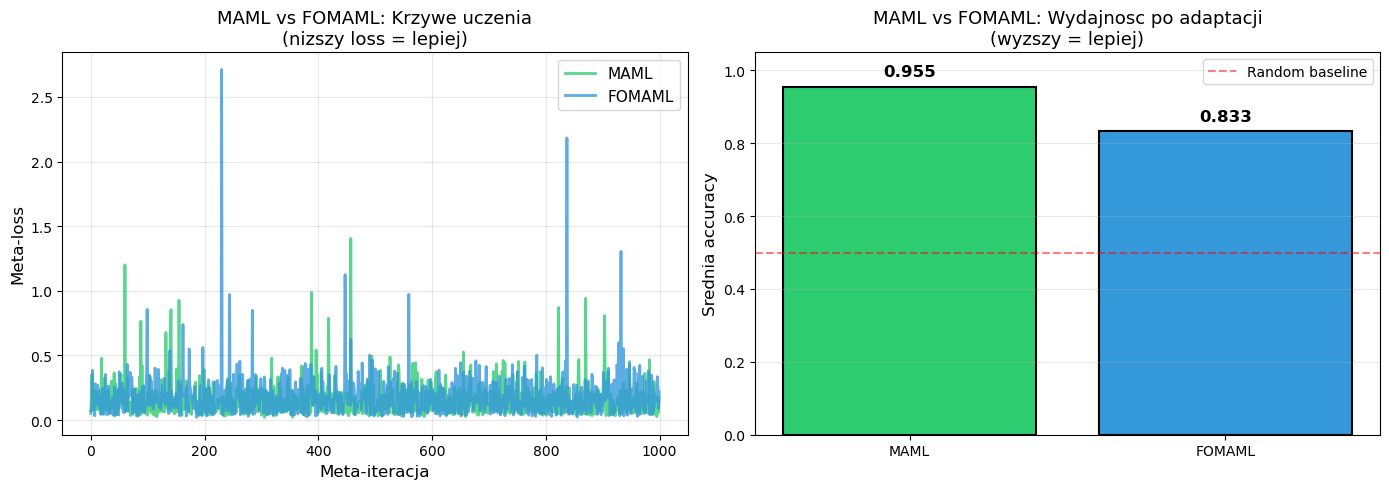


Interpretacja wykresow:
------------------------------------------------------------
Lewy wykres: Pokazuje jak meta-loss spada podczas treningu.
  -> Obie metody zbiegaja do podobnych wartosci.
  -> FOMAML moze byc nieco bardziej szumowy (brak drugich pochodnych).

Prawy wykres: Srednia accuracy na 20 nowych taskach po adaptacji.
  -> Czerwona linia = random baseline (50% dla 2 klas).
  -> Obie metody znaczaco przewyzszaja baseline.

MAML srednia accuracy:   0.955
FOMAML srednia accuracy: 0.833


In [ ]:
# Porównanie MAML vs FOMAML
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: Krzywe uczenia
axes[0].plot(losses, label='MAML', alpha=0.8, linewidth=2, color='#2ecc71')
axes[0].plot(fomaml_losses, label='FOMAML', alpha=0.8, linewidth=2, color='#3498db')
axes[0].set_xlabel('Meta-iteracja', fontsize=12)
axes[0].set_ylabel('Meta-loss', fontsize=12)
axes[0].set_title('MAML vs FOMAML: Krzywe uczenia\n(nizszy loss = lepiej)', fontsize=13)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Wykres 2: Srednia accuracy po adaptacji
maml_accs = []
fomaml_accs = []

for _ in range(20):
    sx, sy, qx, qy = generate_task()
    
    _, maml_acc = evaluate_model(model, sx, sy, qx, qy, inner_lr, inner_steps)
    _, fomaml_acc = evaluate_model(fomaml_model, sx, sy, qx, qy, inner_lr, inner_steps)
    
    maml_accs.append(maml_acc)
    fomaml_accs.append(fomaml_acc)

bars = axes[1].bar(['MAML', 'FOMAML'], 
                   [sum(maml_accs)/len(maml_accs), sum(fomaml_accs)/len(fomaml_accs)],
                   color=['#2ecc71', '#3498db'], edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Srednia accuracy', fontsize=12)
axes[1].set_title('MAML vs FOMAML: Wydajnosc po adaptacji\n(wyzszy = lepiej)', fontsize=13)
axes[1].set_ylim(0, 1.05)
axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random baseline')
axes[1].legend(fontsize=10)
axes[1].grid(True, axis='y', alpha=0.3)

# Dodaj wartosci na slupkach
for bar, val in zip(bars, [sum(maml_accs)/len(maml_accs), sum(fomaml_accs)/len(fomaml_accs)]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{val:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Interpretacja wykresu
print("\nInterpretacja wykresow:")
print("-" * 60)
print("Lewy wykres: Pokazuje jak meta-loss spada podczas treningu")
print("  -> Obie metody zbiegaja do podobnych wartosci")
print("  -> FOMAML moze byc nieco bardziej szumowy (brak drugich pochodnych)")
print()
print("Prawy wykres: Srednia accuracy na 20 nowych taskach po adaptacji")
print("  -> Czerwona linia = random baseline (50% dla 2 klas)")
print("  -> Obie metody znaczaco przewyzszaja baseline")
print()
print(f"MAML srednia accuracy:   {sum(maml_accs)/len(maml_accs):.3f}")
print(f"FOMAML srednia accuracy: {sum(fomaml_accs)/len(fomaml_accs):.3f}")

## Podsumowanie: MAML vs FOMAML

> **FOMAML** to uproszczona wersja MAML, która ignoruje drugie pochodne. Jest szybsza i zużywa mniej pamięci, ale może dawać nieco gorsze wyniki. W praktyce różnica jest często minimalna.

| Cecha | MAML | FOMAML |
|-------|------|--------|
| Drugie pochodne | Tak | Nie |
| Szybkość treningu | Wolniejszy | Szybszy |
| Zużycie pamięci | Wysokie | Niższe |
| Jakość adaptacji | Optymalna | Prawie optymalna |

## Reptile: Najprostsza metoda meta-learningu

### Algorytm Reptile (Nichol et al., 2018)

Reptile jest **znacznie prostszy** niż MAML:

1. Zainicjalizuj parametry $\theta$
2. Dla każdej iteracji:
   - Wylosuj task $T$
   - Skopiuj parametry: $\tilde{\theta} = \theta$
   - Wykonaj $k$ kroków SGD na tasku $T$: $\tilde{\theta} \to \tilde{\theta}'$
   - Meta-update: $\theta \leftarrow \theta + \epsilon(\tilde{\theta}' - \theta)$

[Źródło: Nichol et al., 2018](https://arxiv.org/abs/1803.02999)

---

### Intuicja geometryczna

Każdy task "ciągnie" inicjalizację w swoim kierunku. Po wielu iteracjach, $\theta$ zbliża się do punktu równowagi blisko **wszystkich** optymalnych rozwiązań.

### Zalety Reptile

| Cecha | MAML | FOMAML | Reptile |
|-------|------|--------|---------|
| Drugie pochodne | Tak | Nie | Nie |
| Wymaga query set | Tak | Tak | Nie |
| Złożoność implementacji | Wysoka | Średnia | **Niska** |
| Zużycie pamięci | Wysokie | Średnie | **Niskie** |

In [ ]:
# Reptile - Implementacja

def reptile_inner_loop(model, support_x, support_y, inner_lr, inner_steps):
    """
    Inner loop dla Reptile - zwykły SGD, zwraca zaadaptowany model
    Nie wymaga query set ani drugich pochodnych
    """
    # Kopiujemy model
    adapted_model = SimpleClassifier()
    adapted_model.load_state_dict(model.state_dict())
    
    optimizer = torch.optim.SGD(adapted_model.parameters(), lr=inner_lr)
    
    for _ in range(inner_steps):
        optimizer.zero_grad()
        logits = adapted_model(support_x)
        loss = F.cross_entropy(logits, support_y)
        loss.backward()
        optimizer.step()
    
    return adapted_model

# Trening Reptile
reptile_model = SimpleClassifier()
reptile_lr = 0.001          # meta learning rate (epsilon)
inner_lr_reptile = 0.5
inner_steps_reptile = 10    # więcej kroków niż w MAML
n_reptile_iterations = 1000

reptile_losses = []

print("Trening Reptile:")
print(f"  Meta LR (epsilon): {reptile_lr}, Inner LR: {inner_lr_reptile}")
print(f"  Inner steps: {inner_steps_reptile}")
print("-" * 50)

for meta_iter in range(n_reptile_iterations):
    # Wylosuj task (w Reptile nie potrzebujemy query set)
    support_x, support_y, _, _ = generate_task()
    
    # Inner loop - zwykły SGD
    adapted_model = reptile_inner_loop(
        reptile_model, support_x, support_y, 
        inner_lr_reptile, inner_steps_reptile
    )
    
    # Meta-update: theta = theta + epsilon(theta' - theta)
    with torch.no_grad():
        for (name, param), (_, adapted_param) in zip(
            reptile_model.named_parameters(), 
            adapted_model.named_parameters()
        ):
            param.data += reptile_lr * (adapted_param.data - param.data)
    
    # Opcjonalnie: sledz loss dla wizualizacji
    if meta_iter % 50 == 0:
        sx, sy, qx, qy = generate_task()
        adapted = reptile_inner_loop(reptile_model, sx, sy, inner_lr_reptile, 5)
        with torch.no_grad():
            loss = F.cross_entropy(adapted(qx), qy).item()
        reptile_losses.append(loss)
        
        if meta_iter % 200 == 0:
            print(f"  Iteration {meta_iter:4d} | Test loss: {loss:.4f}")

print("-" * 50)
print("Reptile trening zakończony!")

Trening Reptile:
  Meta LR (epsilon): 0.001, Inner LR: 0.5
  Inner steps: 10
--------------------------------------------------
  Iteration    0 | Test loss: 0.6271
  Iteration  200 | Test loss: 0.0315
  Iteration  400 | Test loss: 0.1538
  Iteration  600 | Test loss: 0.1473
  Iteration  800 | Test loss: 0.1689
--------------------------------------------------
Reptile trening zakończony!


In [23]:
# Ewaluacja Reptile
print("Ewaluacja Reptile na nowych taskach:")
print("-" * 50)

reptile_accs_before = []
reptile_accs_after = []

for i in range(10):
    support_x, support_y, query_x, query_y = generate_task()
    
    # Przed adaptacja
    with torch.no_grad():
        logits = reptile_model(query_x)
        acc_before = (logits.argmax(1) == query_y).float().mean().item()
    
    # Po adaptacji
    adapted = reptile_inner_loop(reptile_model, support_x, support_y, inner_lr_reptile, 5)
    with torch.no_grad():
        logits = adapted(query_x)
        acc_after = (logits.argmax(1) == query_y).float().mean().item()
    
    reptile_accs_before.append(acc_before)
    reptile_accs_after.append(acc_after)
    print(f"  Task {i+1:2d}: Przed={acc_before:.2f} -> Po={acc_after:.2f} (Delta={acc_after-acc_before:+.2f})")

print("-" * 50)
print(f"Reptile srednia przed adaptacja: {sum(reptile_accs_before)/len(reptile_accs_before):.2f}")
print(f"Reptile srednia po adaptacji:    {sum(reptile_accs_after)/len(reptile_accs_after):.2f}")

Ewaluacja Reptile na nowych taskach:
--------------------------------------------------
  Task  1: Przed=0.75 -> Po=0.90 (Delta=+0.15)
  Task  2: Przed=0.50 -> Po=0.50 (Delta=+0.00)
  Task  3: Przed=0.60 -> Po=1.00 (Delta=+0.40)
  Task  4: Przed=0.50 -> Po=0.95 (Delta=+0.45)
  Task  5: Przed=0.05 -> Po=1.00 (Delta=+0.95)
  Task  6: Przed=0.55 -> Po=0.90 (Delta=+0.35)
  Task  7: Przed=0.65 -> Po=0.80 (Delta=+0.15)
  Task  8: Przed=0.50 -> Po=0.50 (Delta=+0.00)
  Task  9: Przed=0.35 -> Po=1.00 (Delta=+0.65)
  Task 10: Przed=0.50 -> Po=1.00 (Delta=+0.50)
--------------------------------------------------
Reptile srednia przed adaptacja: 0.50
Reptile srednia po adaptacji:    0.85


## Podsumowanie: Reptile

> **Reptile** to najprostsza metoda meta-learningu. Nie wymaga drugich pochodnych ani query set. Algorytm przesuwa inicjalizację w kierunku rozwiązań dla kolejnych tasków.

[Źródło: Nichol et al., 2018](https://arxiv.org/abs/1803.02999)

## Meta-SGD: Uczenie się learning rate'ów

### Motywacja

W MAML używamy **jednego learning rate** $\alpha$ dla wszystkich parametrów. Ale różne warstwy mogą wymagać różnych prędkości adaptacji.

### Idea Meta-SGD (Li et al., 2017)

Zamiast uczyć się tylko inicjalizacji $\theta$, uczymy się również **wektora learning rate'ów** $\alpha$:

$$\theta' = \theta - \alpha \odot \nabla_\theta \mathcal{L}(\theta, S)$$

gdzie $\odot$ oznacza mnożenie element-wise, a $\alpha$ ma **taki sam kształt jak $\theta$**.

[Źródło: Li et al., 2017](https://arxiv.org/abs/1707.09835)

---

### Meta-SGD - cechy

| Cecha | Opis |
|-------|------|
| **Co się uczy?** | Inicjalizacja wag $\theta$ + learning rate per parametr $\alpha$ |
| **Zaleta** | Bardziej elastyczna adaptacja |
| **Złożoność** | Podobna do MAML (wymaga drugich pochodnych) |

In [ ]:
# Meta-SGD - Implementacja

class MetaSGDClassifier(nn.Module):
    """
    Model z uczacymi sie learning rate'ami dla kazdego parametru.
    """
    def __init__(self, input_dim=2, hidden_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 2)
        
        # Learning rates jako parametry - jeden LR per parametr
        self.lr_fc1_w = nn.Parameter(torch.ones_like(self.fc1.weight) * 0.01)
        self.lr_fc1_b = nn.Parameter(torch.ones_like(self.fc1.bias) * 0.01)
        self.lr_fc2_w = nn.Parameter(torch.ones_like(self.fc2.weight) * 0.01)
        self.lr_fc2_b = nn.Parameter(torch.ones_like(self.fc2.bias) * 0.01)
        self.lr_fc3_w = nn.Parameter(torch.ones_like(self.fc3.weight) * 0.01)
        self.lr_fc3_b = nn.Parameter(torch.ones_like(self.fc3.bias) * 0.01)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
    def get_params_and_lrs(self):
        """Zwraca pary (parametr, learning_rate)."""
        return [
            (self.fc1.weight, self.lr_fc1_w),
            (self.fc1.bias, self.lr_fc1_b),
            (self.fc2.weight, self.lr_fc2_w),
            (self.fc2.bias, self.lr_fc2_b),
            (self.fc3.weight, self.lr_fc3_w),
            (self.fc3.bias, self.lr_fc3_b),
        ]

def meta_sgd_forward(x, params):
    """Forward pass z podanymi wagami."""
    x = F.linear(x, params[0], params[1])
    x = F.relu(x)
    x = F.linear(x, params[2], params[3])
    x = F.relu(x)
    x = F.linear(x, params[4], params[5])
    return x

def meta_sgd_inner_loop(model, support_x, support_y, inner_steps):
    """
    Inner loop dla Meta-SGD z per-parameter learning rates.
    """
    params_and_lrs = model.get_params_and_lrs()
    
    adapted_params = [p.clone() for p, _ in params_and_lrs]
    learning_rates = [lr for _, lr in params_and_lrs]
    
    for _ in range(inner_steps):
        logits = meta_sgd_forward(support_x, adapted_params)
        loss = F.cross_entropy(logits, support_y)
        
        grads = torch.autograd.grad(loss, adapted_params, create_graph=True)
        
        # Aktualizacja z per-parameter learning rates
        adapted_params = [
            p - lr * g 
            for p, lr, g in zip(adapted_params, learning_rates, grads)
        ]
    
    return adapted_params

# Trening Meta-SGD
meta_sgd_model = MetaSGDClassifier()
meta_sgd_optimizer = torch.optim.Adam(meta_sgd_model.parameters(), lr=0.001)

meta_sgd_losses = []
n_meta_sgd_iterations = 1000

print("Trening Meta-SGD:")
print("-" * 50)

for meta_iter in range(n_meta_sgd_iterations):
    meta_loss = 0.0
    
    for _ in range(n_tasks):
        support_x, support_y, query_x, query_y = generate_task()
        
        adapted_params = meta_sgd_inner_loop(meta_sgd_model, support_x, support_y, inner_steps=3)
        
        query_logits = meta_sgd_forward(query_x, adapted_params)
        task_loss = F.cross_entropy(query_logits, query_y)
        
        meta_loss += task_loss
    
    meta_loss = meta_loss / n_tasks
    
    meta_sgd_optimizer.zero_grad()
    meta_loss.backward()
    meta_sgd_optimizer.step()
    
    meta_sgd_losses.append(meta_loss.item())
    
    if meta_iter % 200 == 0:
        print(f"  Iteration {meta_iter:4d} | Loss: {meta_loss.item():.4f}")

print("-" * 50)
print("Meta-SGD trening zakończony!")

Trening Meta-SGD:
--------------------------------------------------
  Iteration    0 | Loss: 0.6633
  Iteration  200 | Loss: 0.1403
  Iteration  400 | Loss: 0.0795
  Iteration  600 | Loss: 0.2819
  Iteration  800 | Loss: 0.0221
--------------------------------------------------
Meta-SGD trening zakończony!


Nauczone learning rates w Meta-SGD:
--------------------------------------------------
  FC1 weights LR: min=-0.0651, max=0.2984, mean=0.1252
  FC2 weights LR: min=-0.0719, max=0.7176, mean=0.1212
  FC3 weights LR: min=-0.0085, max=0.3113, mean=0.1373


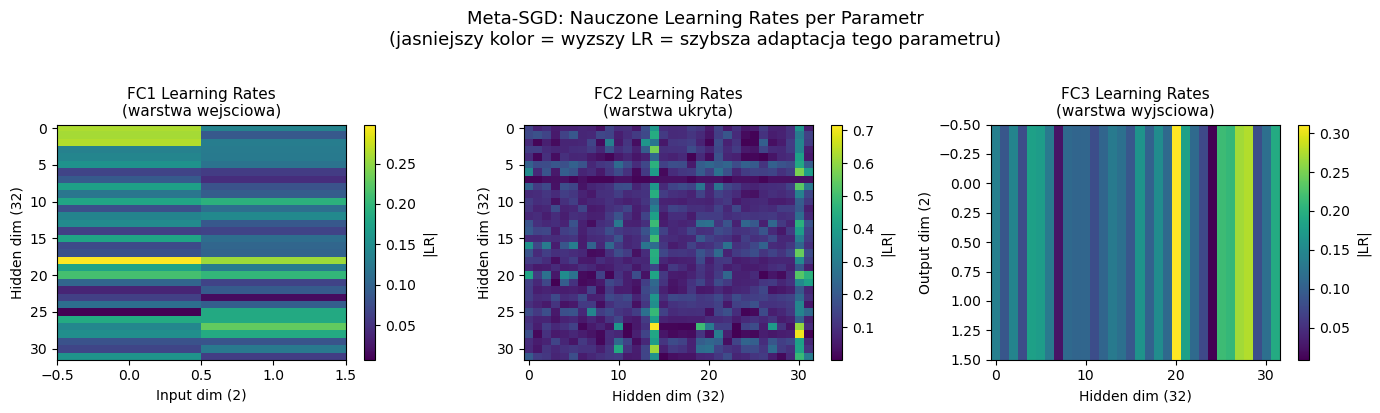


Interpretacja wykresow:
------------------------------------------------------------
Kazda heatmapa pokazuje nauczone learning rates dla wag warstwy.
  -> Jasniejsze kolory = wyzsze LR = szybsza adaptacja
  -> Model nauczyl sie, ktore parametry sa wazne dla adaptacji
  -> Rozne parametry moga miec rozne predkosci uczenia


In [ ]:
# Wizualizacja nauczonych learning rate'ow
print("Nauczone learning rates w Meta-SGD:")
print("-" * 50)

with torch.no_grad():
    print(f"  FC1 weights LR: min={meta_sgd_model.lr_fc1_w.min():.4f}, "
          f"max={meta_sgd_model.lr_fc1_w.max():.4f}, "
          f"mean={meta_sgd_model.lr_fc1_w.mean():.4f}")
    print(f"  FC2 weights LR: min={meta_sgd_model.lr_fc2_w.min():.4f}, "
          f"max={meta_sgd_model.lr_fc2_w.max():.4f}, "
          f"mean={meta_sgd_model.lr_fc2_w.mean():.4f}")
    print(f"  FC3 weights LR: min={meta_sgd_model.lr_fc3_w.min():.4f}, "
          f"max={meta_sgd_model.lr_fc3_w.max():.4f}, "
          f"mean={meta_sgd_model.lr_fc3_w.mean():.4f}")

# Wizualizacja heatmap
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

def tensor_to_array(t):
    """Konwertuje tensor do formatu akceptowanego przez imshow."""
    return t.cpu().detach().numpy()

with torch.no_grad():
    lr1 = tensor_to_array(meta_sgd_model.lr_fc1_w.abs())
    lr2 = tensor_to_array(meta_sgd_model.lr_fc2_w.abs())
    lr3 = tensor_to_array(meta_sgd_model.lr_fc3_w.abs())
    
    im1 = axes[0].imshow(lr1, aspect='auto', cmap='viridis')
    axes[0].set_title('FC1 Learning Rates\n(warstwa wejsciowa)', fontsize=11)
    axes[0].set_xlabel('Input dim (2)', fontsize=10)
    axes[0].set_ylabel('Hidden dim (32)', fontsize=10)
    plt.colorbar(im1, ax=axes[0], label='|LR|')
    
    im2 = axes[1].imshow(lr2, aspect='auto', cmap='viridis')
    axes[1].set_title('FC2 Learning Rates\n(warstwa ukryta)', fontsize=11)
    axes[1].set_xlabel('Hidden dim (32)', fontsize=10)
    axes[1].set_ylabel('Hidden dim (32)', fontsize=10)
    plt.colorbar(im2, ax=axes[1], label='|LR|')
    
    im3 = axes[2].imshow(lr3, aspect='auto', cmap='viridis')
    axes[2].set_title('FC3 Learning Rates\n(warstwa wyjsciowa)', fontsize=11)
    axes[2].set_xlabel('Hidden dim (32)', fontsize=10)
    axes[2].set_ylabel('Output dim (2)', fontsize=10)
    plt.colorbar(im3, ax=axes[2], label='|LR|')

plt.suptitle('Meta-SGD: Nauczone Learning Rates per Parametr\n(jasniejszy kolor = wyzszy LR = szybsza adaptacja tego parametru)', 
             fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# Interpretacja
print("\nInterpretacja wykresow:")
print("-" * 60)
print("Kazda heatmapa pokazuje nauczone learning rates dla wag warstwy")
print("  -> Jasniejsze kolory = wyzsze LR = szybsza adaptacja")
print("  -> Model nauczyl sie, ktore parametry sa wazne dla adaptacji")
print("  -> Rozne parametry moga miec rozne predkosci uczenia")

## Podsumowanie: Meta-SGD

> **Meta-SGD** rozszerza MAML o uczenie się learning rate per parametr. Pozwala modelowi odkryć, które parametry są ważne dla szybkiej adaptacji i jak szybko je zmieniać.

[Źródło: Li et al., 2017](https://arxiv.org/abs/1707.09835)

## Wielkie porównanie wszystkich metod Meta-Learning

| Metoda | Drugie pochodne | Wymaga query set | Złożoność | Pamięć |
|--------|-----------------|------------------|-----------|--------|
| **MAML** | Tak | Tak | Wysoka | Wysoka |
| **FOMAML** | Nie | Tak | Średnia | Średnia |
| **Reptile** | Nie | Nie | Niska | Niska |
| **Meta-SGD** | Tak | Tak | Wysoka | Wysoka |

### Kiedy używać której metody?

| Scenariusz | Rekomendacja |
|------------|--------------|
| Masz dużo zasobów obliczeniowych | **MAML** lub **Meta-SGD** |
| Potrzebujesz szybkiego treningu | **FOMAML** |
| Prostota jest priorytetem | **Reptile** |
| Nie masz query set | **Reptile** |
| Różne parametry wymagają różnych LR | **Meta-SGD** |

In [ ]:
# Wielkie porównanie wszystkich metod

def adapt_reptile(model, sx, sy, qx, qy):
    adapted = reptile_inner_loop(model, sx, sy, 0.5, 5)
    with torch.no_grad():
        logits = adapted(qx)
        return (logits.argmax(1) == qy).float().mean().item()

def adapt_meta_sgd(model, sx, sy, qx, qy):
    adapted_params = meta_sgd_inner_loop(model, sx, sy, 3)
    with torch.no_grad():
        logits = meta_sgd_forward(qx, adapted_params)
        return (logits.argmax(1) == qy).float().mean().item()

# Ewaluacja wszystkich metod
print("Porównanie metod Meta-Learning (20 tasków każda):")
print("=" * 60)

results = {}

# MAML
maml_before, maml_after = [], []
for _ in range(20):
    sx, sy, qx, qy = generate_task()
    b, a = evaluate_model(model, sx, sy, qx, qy, inner_lr, inner_steps)
    maml_before.append(b)
    maml_after.append(a)
results['MAML'] = (maml_before, maml_after)

# FOMAML
fomaml_before, fomaml_after = [], []
for _ in range(20):
    sx, sy, qx, qy = generate_task()
    b, a = evaluate_model(fomaml_model, sx, sy, qx, qy, inner_lr, inner_steps)
    fomaml_before.append(b)
    fomaml_after.append(a)
results['FOMAML'] = (fomaml_before, fomaml_after)

# Reptile
reptile_before, reptile_after = [], []
for _ in range(20):
    sx, sy, qx, qy = generate_task()
    with torch.no_grad():
        b = (reptile_model(qx).argmax(1) == qy).float().mean().item()
    a = adapt_reptile(reptile_model, sx, sy, qx, qy)
    reptile_before.append(b)
    reptile_after.append(a)
results['Reptile'] = (reptile_before, reptile_after)

# Meta-SGD
meta_sgd_before, meta_sgd_after = [], []
for _ in range(20):
    sx, sy, qx, qy = generate_task()
    with torch.no_grad():
        b = (meta_sgd_model(qx).argmax(1) == qy).float().mean().item()
    a = adapt_meta_sgd(meta_sgd_model, sx, sy, qx, qy)
    meta_sgd_before.append(b)
    meta_sgd_after.append(a)
results['Meta-SGD'] = (meta_sgd_before, meta_sgd_after)

# Wyniki
print(f"{'Metoda':<12} | {'Przed':<8} | {'Po':<8} | {'Poprawa':<8}")
print("-" * 45)
for name, (before, after) in results.items():
    avg_before = sum(before)/len(before)
    avg_after = sum(after)/len(after)
    gain = avg_after - avg_before
    print(f"{name:<12} | {avg_before:.3f}    | {avg_after:.3f}    | {gain:+.3f}")

Porównanie metod Meta-Learning (20 tasków każda):
Metoda       | Przed    | Po       | Poprawa 
---------------------------------------------
MAML         | 0.687    | 0.943    | +0.255
FOMAML       | 0.503    | 0.932    | +0.430
Reptile      | 0.532    | 0.995    | +0.463
Meta-SGD     | 0.457    | 0.985    | +0.528


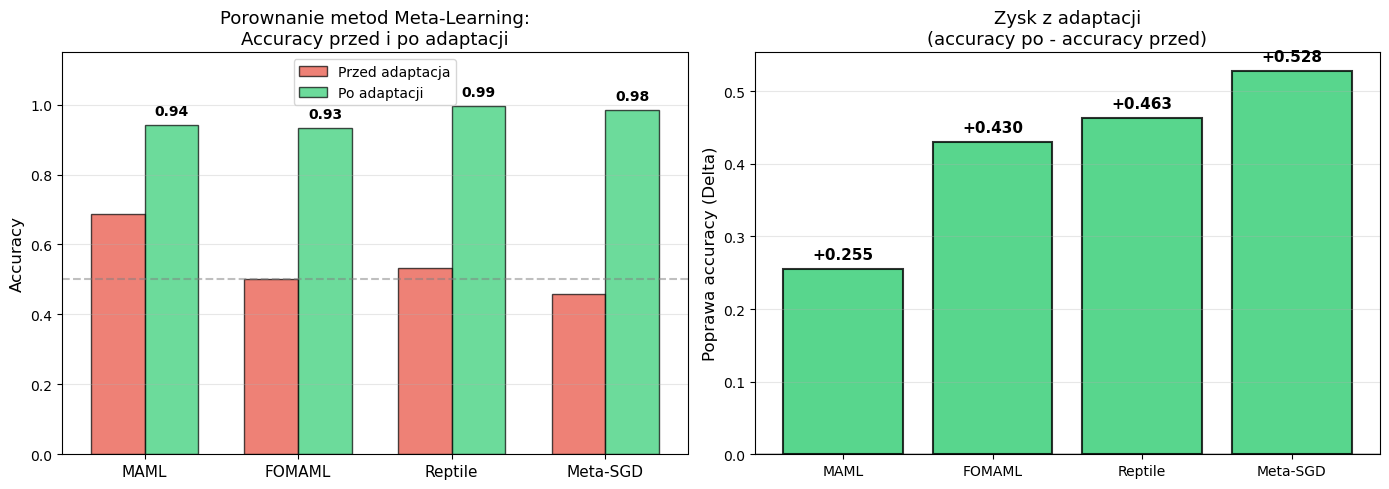


Interpretacja wykresow:
------------------------------------------------------------
Lewy wykres: Porownanie accuracy przed (czerwony) i po (zielony) adaptacji.
  -> Wszystkie metody znaczaco poprawiaja sie po adaptacji
  -> Szara linia = random baseline (50%)

Prawy wykres: Zysk z adaptacji (roznica after - before).
  -> Wyzszy slupek = wieksza poprawa dzieki adaptacji
  -> Wszystkie metody skutecznie adaptuja sie do nowych taskow

Wnioski:
  - Wszystkie metody skutecznie adaptuja sie do nowych taskow
  - MAML i Meta-SGD moga dawac najlepsze wyniki (pelne drugie pochodne)
  - FOMAML jest dobrym kompromisem miedzy wydajnoscia a zlozonoscia
  - Reptile jest najprostszy, ale rowniez skuteczny


In [ ]:
# Wizualizacja porownawcza
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: Accuracy przed i po adaptacji
methods = list(results.keys())
before_means = [sum(results[m][0])/len(results[m][0]) for m in methods]
after_means = [sum(results[m][1])/len(results[m][1]) for m in methods]

x = range(len(methods))
width = 0.35
colors_before = ['#e74c3c', '#e74c3c', '#e74c3c', '#e74c3c']
colors_after = ['#2ecc71', '#27ae60', '#1abc9c', '#16a085']

bars1 = axes[0].bar([i - width/2 for i in x], before_means, width, 
                    label='Przed adaptacja', color='#e74c3c', alpha=0.7, edgecolor='black')
bars2 = axes[0].bar([i + width/2 for i in x], after_means, width, 
                    label='Po adaptacji', color='#2ecc71', alpha=0.7, edgecolor='black')

axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Porownanie metod Meta-Learning:\nAccuracy przed i po adaptacji', fontsize=13)
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods, fontsize=11)
axes[0].legend(fontsize=10)
axes[0].set_ylim(0, 1.15)
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
axes[0].grid(True, axis='y', alpha=0.3)

# Dodaj wartosci na slupkach
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Wykres 2: Zysk z adaptacji
gains = [after_means[i] - before_means[i] for i in range(len(methods))]
colors = ['#2ecc71' if g > 0 else '#e74c3c' for g in gains]
bars = axes[1].bar(methods, gains, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Poprawa accuracy (Delta)', fontsize=12)
axes[1].set_title('Zysk z adaptacji\n(accuracy po - accuracy przed)', fontsize=13)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].grid(True, axis='y', alpha=0.3)

# Dodaj wartosci na slupkach
for bar, val in zip(bars, gains):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{val:+.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Interpretacja
print("\nInterpretacja wykresow:")
print("-" * 60)
print("Lewy wykres: Porownanie accuracy przed (czerwony) i po (zielony) adaptacji.")
print("  -> Wszystkie metody znaczaco poprawiaja sie po adaptacji")
print("  -> Szara linia = random baseline (50%)")
print()
print("Prawy wykres: Zysk z adaptacji (roznica after - before).")
print("  -> Wyzszy slupek = wieksza poprawa dzieki adaptacji")
print("  -> Wszystkie metody skutecznie adaptuja sie do nowych taskow")
print()
print("Wnioski:")
print("  - Wszystkie metody skutecznie adaptuja sie do nowych taskow")
print("  - MAML i Meta-SGD moga dawac najlepsze wyniki (pelne drugie pochodne)")
print("  - FOMAML jest dobrym kompromisem miedzy wydajnoscia a zlozonoscia")
print("  - Reptile jest najprostszy, ale rowniez skuteczny")

## Zaawansowane aspekty Meta-Learningu

### 1. Task Distribution

Wydajność meta-learningu silnie zależy od **dystrybucji tasków**:
- Taski treningowe powinny być podobne do tasków testowych
- Optymalna trudność = taski rozwiązywalne po adaptacji

### 2. Liczba kroków adaptacji

| Mało kroków (1-3) | Dużo kroków (10+) |
|-------------------|-------------------|
| Szybsza adaptacja | Lepsza wydajność |
| Mniej overfittingu | Ryzyko overfittingu |
| Wymaga lepszej inicjalizacji | Bardziej elastyczne |

### 3. Skalowanie do większych modeli

Dla dużych modeli (ResNet, Transformers):
- MAML jest bardzo kosztowny pamięciowo
- FOMAML lub Reptile są praktyczniejsze
- Można adaptować tylko część warstw (np. ostatnie)

### 4. Meta-Learning w innych domenach

| Domena | Zastosowanie |
|--------|--------------|
| **Reinforcement Learning** | Szybka adaptacja do nowych zadań |
| **NLP** | Few-shot learning dla nowych języków |
| **Drug Discovery** | Uczenie z małej liczby próbek |
| **Robotics** | Adaptacja do nowych środowisk |

[Źródło: Hospedales et al., 2021](https://arxiv.org/abs/2004.05439)

## Porównanie: Metric-Based vs Meta-Learning

| Aspekt | Prototypical Networks | MAML |
|--------|----------------------|------|
| **Co się uczy?** | Embedding space | Inicjalizacja wag |
| **Adaptacja wag podczas inference?** | Nie | Tak |
| **Złożoność obliczeniowa** | Niska | Wysoka |
| **Elastyczność** | Tylko klasyfikacja | Dowolne zadanie |
| **Wymagania pamięci** | Niskie | Wysokie |
| **Łatwość implementacji** | Prosta | Trudniejsza |

### Kiedy używać czego?

| Scenariusz | Rekomendacja |
|------------|--------------|
| Dobre pretrenowane embeddingi | **Metric-based** (ProtoNet) |
| Proste zadania klasyfikacyjne | **Metric-based** |
| Szybka inference | **Metric-based** |
| Zadania wymagające adaptacji | **Meta-learning** (MAML) |
| Różnorodne typy zadań | **Meta-learning** |
| Zadania inne niż klasyfikacja (regresja, RL) | **Meta-learning** |

---

## Podsumowanie całego notebooka

### Główne wnioski

1. **Meta-learning** uczy model **jak się uczyć** – znajduje dobrą inicjalizację wag
2. **MAML** używa gradientów przez gradienty (drugie pochodne) dla optymalnej adaptacji
3. **FOMAML** i **Reptile** to prostsze alternatywy bez drugich pochodnych
4. **Meta-SGD** dodatkowo uczy się learning rate per parametr
5. Wszystkie metody skutecznie adaptują się do nowych tasków z kilku przykładów

### Porównanie z metric-based

- **Metric-based**: prostsze, szybsze, ale ograniczone do klasyfikacji
- **Meta-learning**: bardziej elastyczne, ale kosztowniejsze obliczeniowo

[Źródło: Finn et al., 2017 - MAML](https://arxiv.org/abs/1703.03400)

[Źródło: Nichol et al., 2018 - Reptile](https://arxiv.org/abs/1803.02999)

[Źródło: Li et al., 2017 - Meta-SGD](https://arxiv.org/abs/1707.09835)

---

# Ćwiczenia

## Ćwiczenie 2 (Obowiązkowe): Implementacja MAML Inner Loop

**Zadanie:** Uzupełnij poniższy kod, implementując pętlę wewnętrzną (inner loop) MAML.

Musisz:
1. **TODO 1:** Wykonać forward pass z aktualnymi wagami
2. **TODO 2:** Obliczyć gradienty i zaktualizować wagi
3. **TODO 3:** Obliczyć loss na query set po adaptacji
4. **TODO 4:** Obliczyć accuracy przed i po adaptacji

In [ ]:
# Ćwiczenie 2: Implementacja MAML Inner Loop
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)

# Model
class TinyClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Funkcja generująca task
def create_task():
    angle = torch.rand(1) * 2 * 3.14159
    direction = torch.tensor([torch.cos(angle), torch.sin(angle)]).squeeze()
    offset = torch.randn(2) * 2
    c0, c1 = offset - direction * 2, offset + direction * 2
    
    sx = torch.cat([torch.randn(5, 2) * 0.5 + c0, torch.randn(5, 2) * 0.5 + c1])
    sy = torch.cat([torch.zeros(5), torch.ones(5)]).long()
    qx = torch.cat([torch.randn(10, 2) * 0.5 + c0, torch.randn(10, 2) * 0.5 + c1])
    qy = torch.cat([torch.zeros(10), torch.ones(10)]).long()
    
    return sx, sy, qx, qy

# Forward funkcjonalny
def tiny_forward(x, params):
    x = F.linear(x, params['fc1.weight'], params['fc1.bias'])
    x = F.relu(x)
    x = F.linear(x, params['fc2.weight'], params['fc2.bias'])
    return x

# Parametry
inner_lr = 0.5
inner_steps = 5

# Inicjalizacja modelu
exercise_model = TinyClassifier()

# Generuj task
support_x, support_y, query_x, query_y = create_task()

# Pobierz parametry
params = {k: v.clone() for k, v in exercise_model.named_parameters()}

# Accuracy PRZED adaptacją
with torch.no_grad():
    logits_before = tiny_forward(query_x, params)
    preds_before = logits_before.argmax(dim=1)
    acc_before = (preds_before == query_y).float().mean().item()
    print(f"Accuracy PRZED adaptacją: {acc_before:.2f}")

# TODO: Inner loop - adaptacja na support set
# Wykonaj `inner_steps` kroków gradient descent
adapted_params = {k: v.clone() for k, v in params.items()}

for step in range(inner_steps):
    # TODO 1: Forward pass z adapted_params
    # Użyj funkcji tiny_forward(support_x, adapted_params)
    logits = None  # <-- UZUPEŁNIJ
    
    # TODO 2: Oblicz loss i gradienty, zaktualizuj adapted_params
    # Użyj F.cross_entropy() i torch.autograd.grad()
    loss = None  # <-- UZUPEŁNIJ
    grads = None  # <-- UZUPEŁNIJ
    
    # Aktualizacja wag (odkomentuj po uzupełnieniu powyższego)
    # adapted_params = {
    #     k: v - inner_lr * g 
    #     for (k, v), g in zip(adapted_params.items(), grads)
    # }

# TODO 3: Oblicz accuracy PO adaptacji
with torch.no_grad():
    # Użyj tiny_forward z adapted_params
    logits_after = None  # <-- UZUPEŁNIJ
    preds_after = None   # <-- UZUPEŁNIJ (użyj .argmax(dim=1))
    acc_after = None     # <-- UZUPEŁNIJ (porównaj z query_y)

# Odkomentuj po uzupełnieniu:
# print(f"Accuracy PO adaptacji: {acc_after:.2f}")
# print(f"Poprawa: {acc_after - acc_before:+.2f}")

Accuracy PRZED adaptacją: 0.65
